This notebook explains how to run a simple 2-dimension example of `Diva`.    
The input files and the figures are created within the notebook.    
The reading/writing of input files is done through specific classes defined in [pydiva2d](./pydiva2d.py).

In [1]:
import os
import logging
import shutil
import subprocess
import numpy as np
import pydiva2d

# Setup 

## Logging configuration

The *logging* is already configured in `pydiva2d`.<br>
Replace 'DEBUG' by 'INFO', 'WARNING' or 'ERROR'.

In [2]:
logger = logging.getLogger('pydiva2d')
logger.handlers[1].setLevel(logging.DEBUG)

## Diva configuration

Set the path to the `Diva` installation you want to work with.

In [3]:
divadir = "/home/ctroupin/Software/DIVA/DIVA-diva-4.7.1"

# Prepare the input files
## Directories
Create variables storing the `Diva` directories.

In [4]:
DivaDirs = pydiva2d.DivaDirectories(divadir)

2017-07-10 07:54:59,661 - pydiva2d - DEBUG - /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1 exists
2017-07-10 07:54:59,664 - pydiva2d - INFO - Diva main directory: /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1
2017-07-10 07:54:59,665 - pydiva2d - INFO - Creating Diva directory paths
2017-07-10 07:54:59,666 - pydiva2d - INFO - Binary directory:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/bin
2017-07-10 07:54:59,667 - pydiva2d - INFO - Source directory:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/src/Fortran
2017-07-10 07:54:59,668 - pydiva2d - INFO - Main 2D directory:  /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped
2017-07-10 07:54:59,669 - pydiva2d - INFO - Main 4D directory:  /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/JRA4/Climatology
2017-07-10 07:54:59,670 - pydiva2d - INFO - Example directory:  /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/Example4D/


Create variables storing the main `Diva` input and output files.

In [5]:
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

2017-07-10 07:55:14,824 - pydiva2d - INFO - Creating Diva 2D file names and paths
2017-07-10 07:55:14,824 - pydiva2d - INFO - Contour file:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/coast.cont
2017-07-10 07:55:14,825 - pydiva2d - INFO - Parameter file: /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/param.par
2017-07-10 07:55:14,826 - pydiva2d - INFO - Data file:      /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/data.dat
2017-07-10 07:55:14,827 - pydiva2d - INFO - Valatxy file:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord
2017-07-10 07:55:14,828 - pydiva2d - INFO - Result file:    /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/output/ghertonetcdf/results.nc
2017-07-10 07:55:14,829 - pydiva2d - INFO - Mesh file:      /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.22
2017-07-10 07:55:14,830 - pydiva2d - INFO - Mesh 

## Contour

Create a sequence of points representing the contour (no crossing, no duplicate points, etc).     
It is not necessary to close the contour (i.e., setting the last point equal to the first point).    
Each coordinate (lon, lat) is defined as a [ndarray](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html) or a list of lists (one per sub-contour).

In [6]:
lon = np.array([[0., 2., 2., 0.], [2.5, 6., 6., 2.5]])
lat = np.array([[0., 0., 4., 4.], [0., 0., 3., 3.]]) 

Create a **contour** object using the coordinates: 

In [7]:
contour2D = pydiva2d.Diva2DContours(lon, lat)

2017-07-10 07:56:25,110 - pydiva2d - INFO - Creating Diva 2D contour object


and write its content to the corresponding file defined in the **DivaFile** object:

In [8]:
contour2D.write_to(DivaFiles.contour)

2017-07-10 07:56:30,165 - pydiva2d - INFO - Number of contours: 2
2017-07-10 07:56:30,167 - pydiva2d - INFO - Number of contours: 2
2017-07-10 07:56:30,172 - pydiva2d - DEBUG - Sub-contour no. 1 has 4 points
2017-07-10 07:56:30,172 - pydiva2d - DEBUG - Sub-contour no. 2 has 4 points
2017-07-10 07:56:30,173 - pydiva2d - INFO - Written contours into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/coast.cont


## Data

Create arrays of coordinates (*x*, *y*), values (*z*) and optionnaly weights (*w*) representing the data points.     
If the weights are not specified, it is assumed that all the data points have an identical weight (equal to 1).

In [9]:
x = np.array((1.2, 1.75, 3., 5.5))  
y = np.array((2.1, 3.5, 2., 0.2))
z = np.array((1., -2., 4, -1))
w = np.array((1., 1., 0.5, 0.5))

Similarly to the contour, we create a **data** object:

In [10]:
data2D = pydiva2d.Diva2DData(x, y, z, w)

2017-07-10 07:56:46,991 - pydiva2d - INFO - Creating Diva 2D data object


and we write the values to the specified file:

In [11]:
data2D.write_to(DivaFiles.data)

2017-07-10 07:56:49,834 - pydiva2d - INFO - Written data into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/data.dat


## Parameters

We need to set the parameters defining the domain and the analysis parameters.    
Check the [`Diva` documentation](http://github.com/gher-ulg/) to have a complete description of each parameter.

First we set the output grid (limits and spatial resolution).

In [12]:
xmin, ymin, nx, ny, dx, dy = 0.0, 0.0, 61, 81, 0.1, 0.05

Then the parameters specific to the analysis:

In [13]:
CorrelationLength = 1.5
SignalToNoiseRatio = 0.5
VarianceBackgroundField = 1.0
ExclusionValue = -999.
iCoordChange = 0
iSpec = 11
iReg = 0

We create a **parameter** object that stores all the parameter values:

In [14]:
parameters2D = pydiva2d.Diva2DParameters(CorrelationLength, iCoordChange, iSpec, iReg, xmin, ymin, dx, dy, nx, ny,
                                ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField)

2017-07-10 07:59:52,482 - pydiva2d - INFO - Creating Diva 2D parameter object


and we write them into a file:

In [15]:
parameters2D.write_to(DivaFiles.parameter)

2017-07-10 07:59:54,308 - pydiva2d - INFO - Written parameters into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/param.par


## List of extra points

In the optional input file *valatxy.coord*, one can specify additional locations where the interpolation has to be performed.<br>
Here we ask for the analysis at the location of the first two data points, plus at an additional location.

In [16]:
xcoord = np.array((1.2, 1.75, 5.9))  
ycoord = np.array((2.1, 3.5, 3.9))

We create the object **valatxy** and write the coordinates to a file:

In [17]:
valatxy = pydiva2d.Diva2DValatxy(xcoord, ycoord)
valatxy.write_to(DivaFiles.valatxy)

2017-07-10 08:00:02,371 - pydiva2d - INFO - Creating Diva 2D valatxy object
2017-07-10 08:00:02,373 - pydiva2d - INFO - Written locations into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord


# Run Diva
Now that the input files have been created we can perform a Diva analysis.
## Mesh generation

In [18]:
logger.info("Starting generation of the finite-element mesh")
meshprocess = subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, stdout=subprocess.PIPE, shell=True)
out = meshprocess.stdout.read()
with open(pydiva2d.logfile, 'a') as f:
    f.write(str(out).replace('\\n', '\n'))
logger.info("Finished generation of the finite-element mesh")

2017-06-09 11:51:27,321 - pydiva2d - INFO - Starting generation of the finite-element mesh
2017-06-09 11:51:27,370 - pydiva2d - INFO - Finished generation of the finite-element mesh


## Run the diva calculation

In [19]:
logger.info("Starting computation of the gridded field")
calcprocess = subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, stdout=subprocess.PIPE, shell=True)
out = calcprocess.stdout.read()
with open(pydiva2d.logfile, 'a') as f:
    f.write(str(out).replace('\\n', '\n'))
logger.info("Finished computation of the gridded field")

2017-06-09 11:51:27,864 - pydiva2d - INFO - Starting computation of the gridded field
2017-06-09 11:51:28,143 - pydiva2d - INFO - Finished computation of the gridded field


# Time for some plots

We import a few more modules to plot the input files content and the results.<br>
The last line asks for the plot to be done within the notebook, not as external window.

In [20]:
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [21]:
rcParams.update({'font.size': 12, 'figure.dpi': 300})

## Input files

Let's represent the observations, the grid and the contours.<br>
By default, each contour is represented in a different color.

2017-06-09 11:51:31,451 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:51:31,453 - pydiva2d - DEBUG - Adding contours to plot
2017-06-09 11:51:31,517 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:51:31,518 - pydiva2d - DEBUG - Adding data points to plot
2017-06-09 11:51:31,534 - pydiva2d - DEBUG - Adding output grid to plot


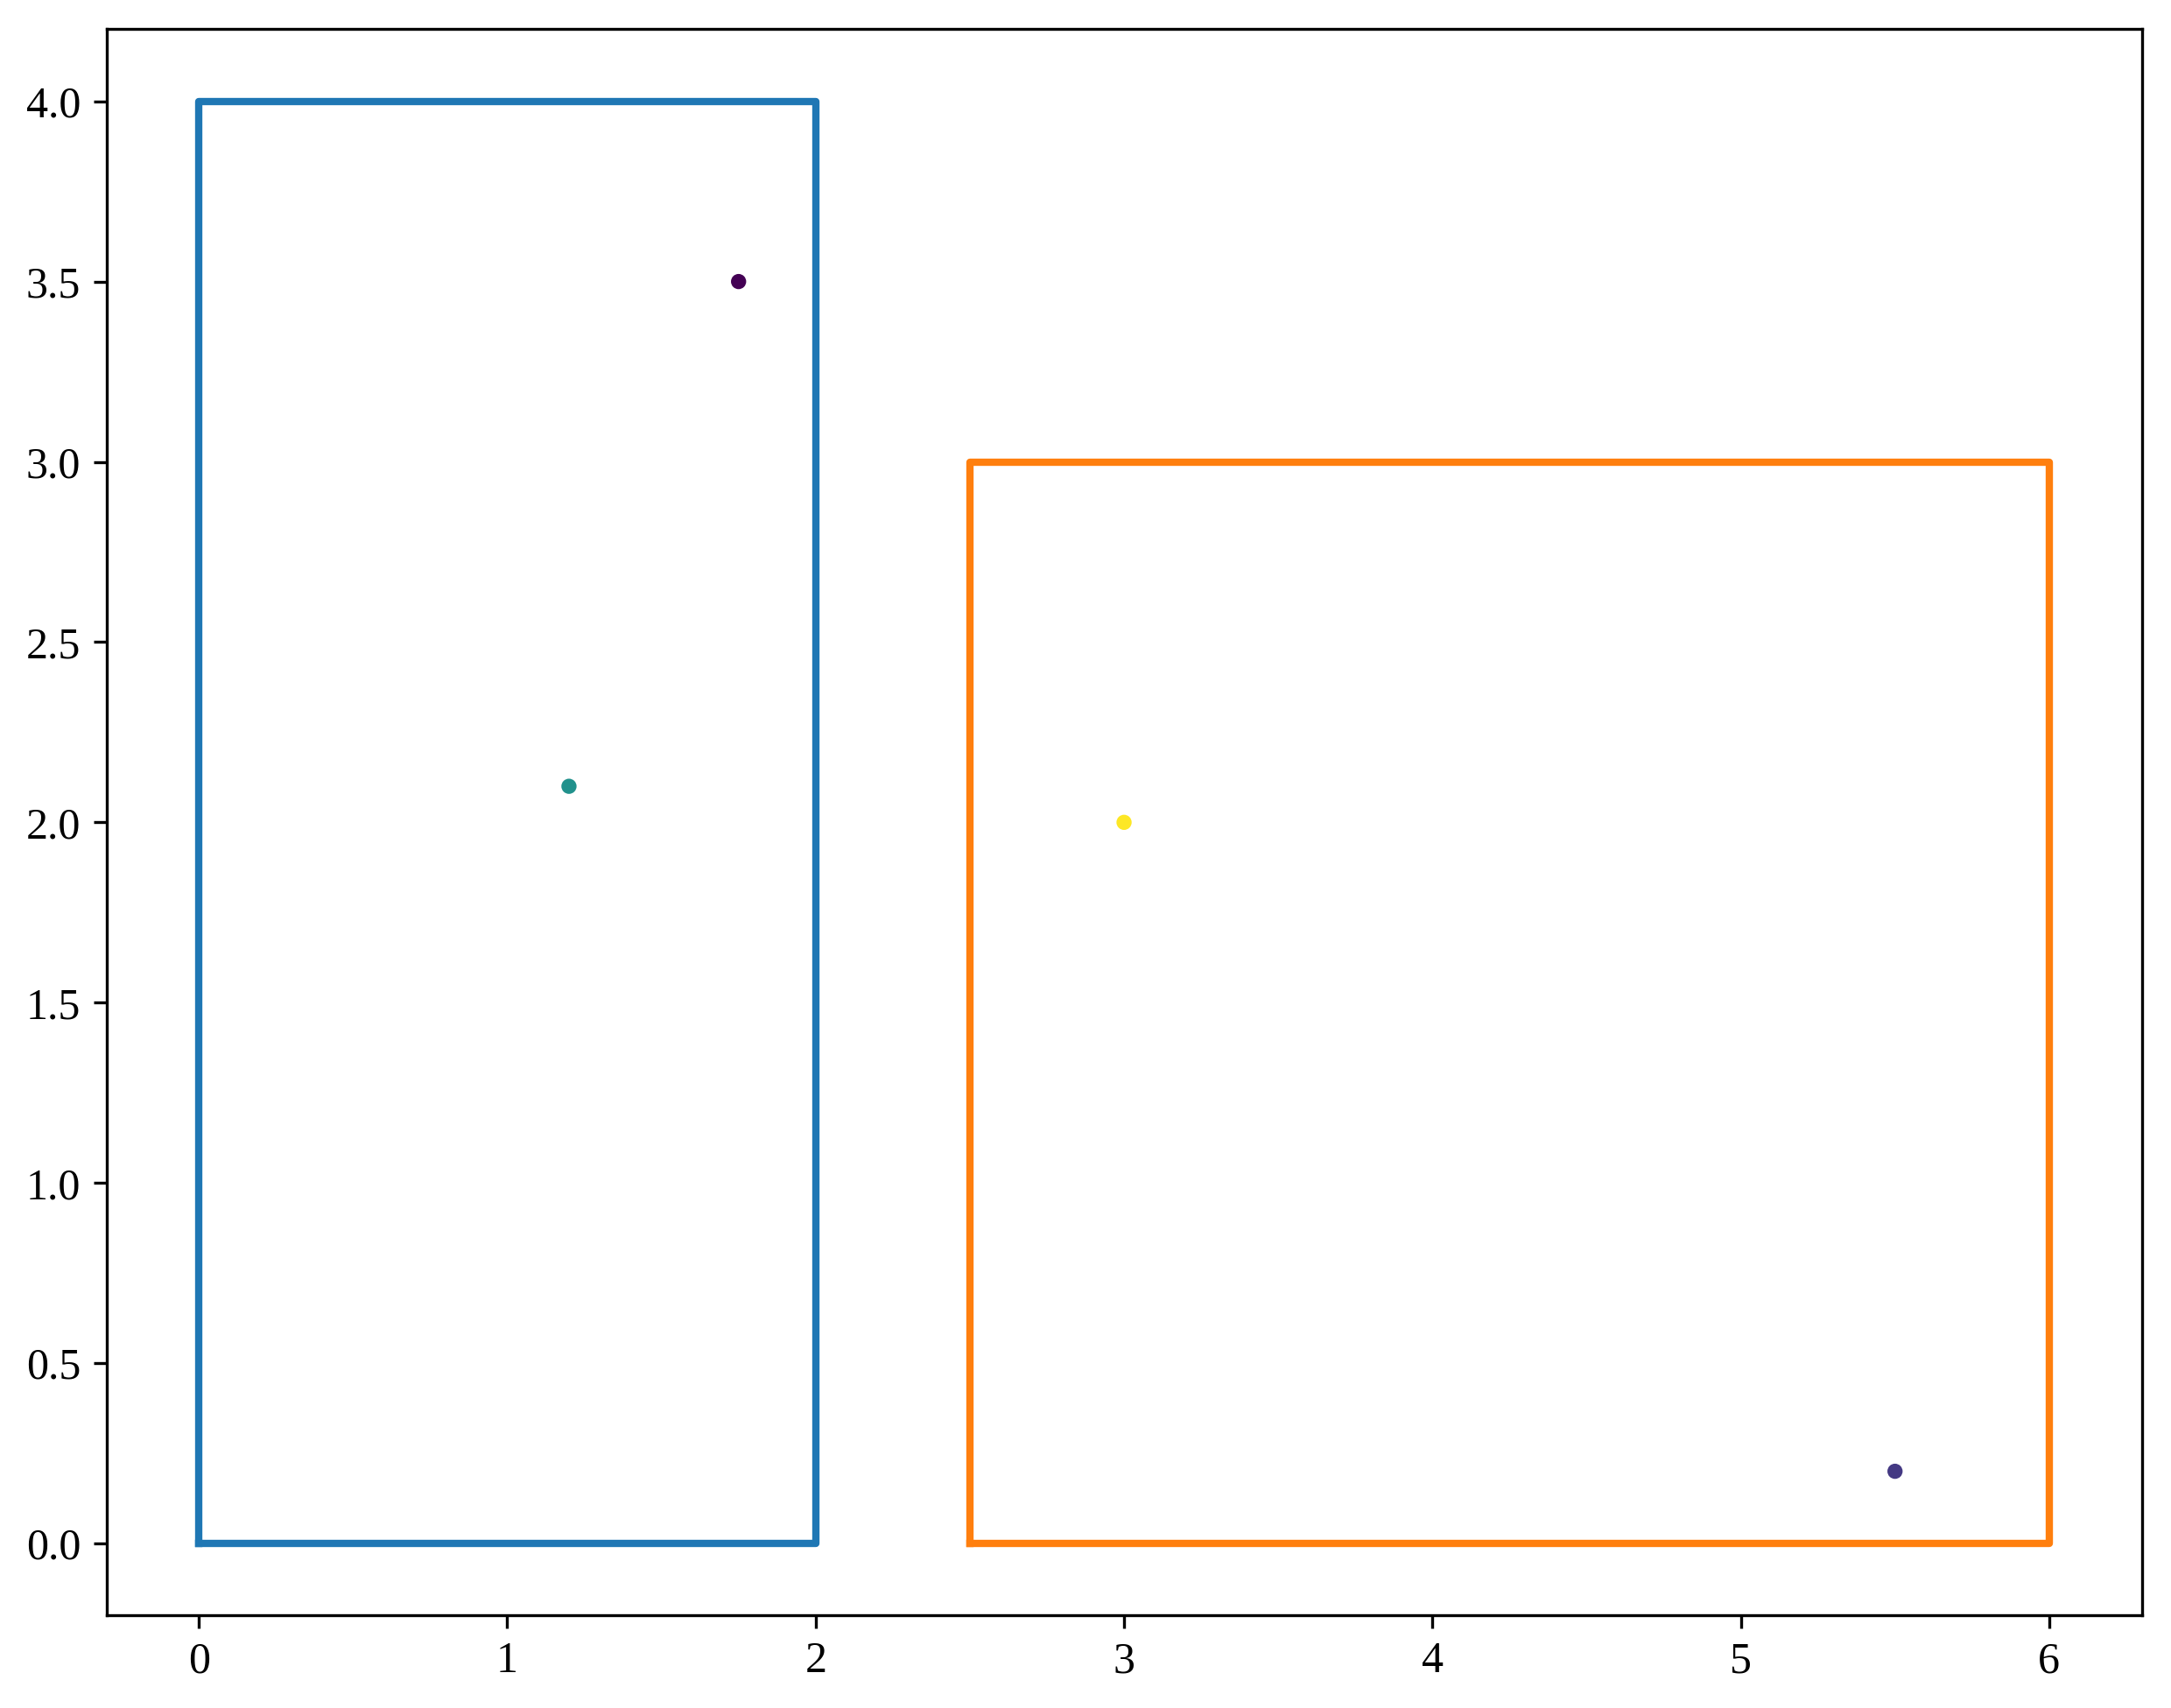

In [22]:
fig = plt.figure()
contour2D.add_to_plot(linewidth=2)
data2D.add_to_plot(s=10)
parameters2D.plot_outputgrid()
plt.show()
plt.close()

## Results 

The results are stored in a netCDF file that we can access using the **resultfile** property of **DivaFile** object.

### Analysis

The field is then added to the plot. In addition we can include the locations of the observations.<br>
Note that, due to their lower weights, the 2 data points in the right-side domain seems to influence less the analysis.

2017-06-09 11:53:28,963 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:53:28,964 - pydiva2d - DEBUG - Adding analysed field to plot
2017-06-09 11:53:29,000 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:53:29,001 - pydiva2d - DEBUG - Adding data points to plot


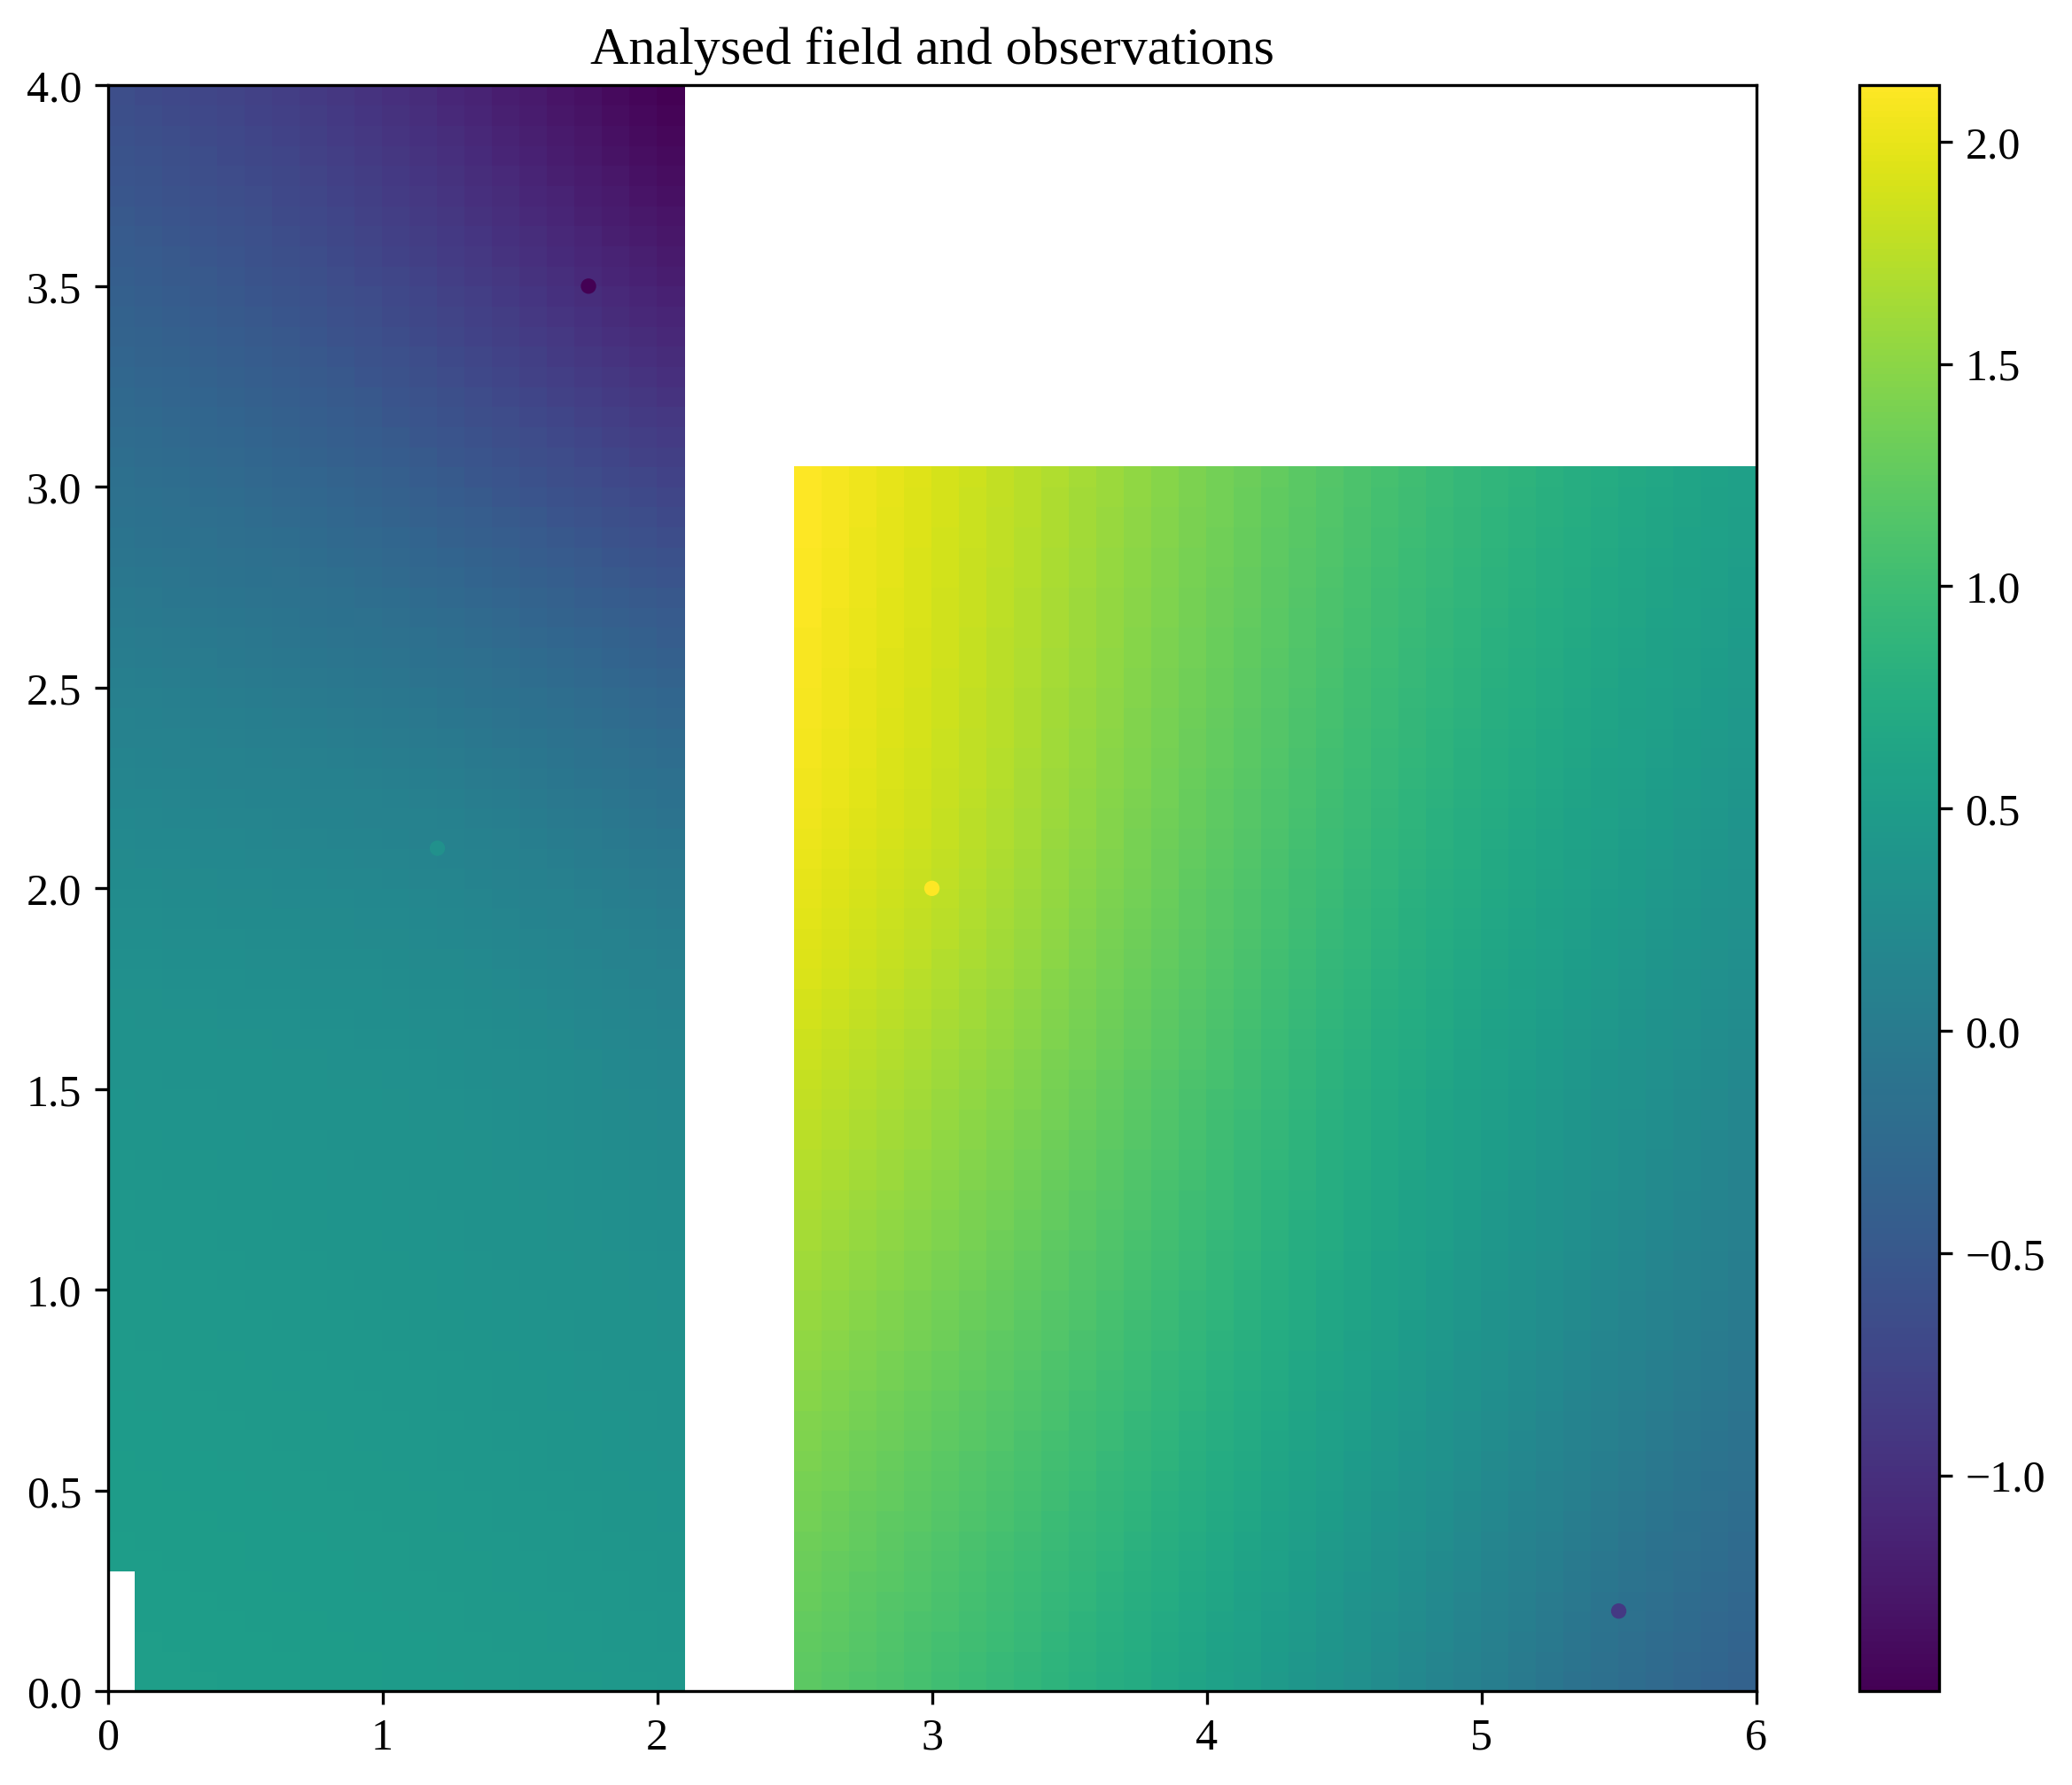

In [23]:
fig = plt.figure()
results2D = pydiva2d.Diva2DResults(DivaFiles.result)
fieldplot = results2D.add_to_plot('analysis')
data2D.add_to_plot(s=10)
plt.colorbar(fieldplot)
plt.title('Analysed field and observations')
plt.show()
plt.close()

### Error field

The error field is represented using a similar command.<br>
Also note the larger error values in the right-hand side, due to the lower weights of the data points in that part of the domain.

2017-06-09 11:53:42,449 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:53:42,450 - pydiva2d - DEBUG - Adding error field to plot
2017-06-09 11:53:42,453 - pydiva2d - DEBUG - Adding data positions to plot


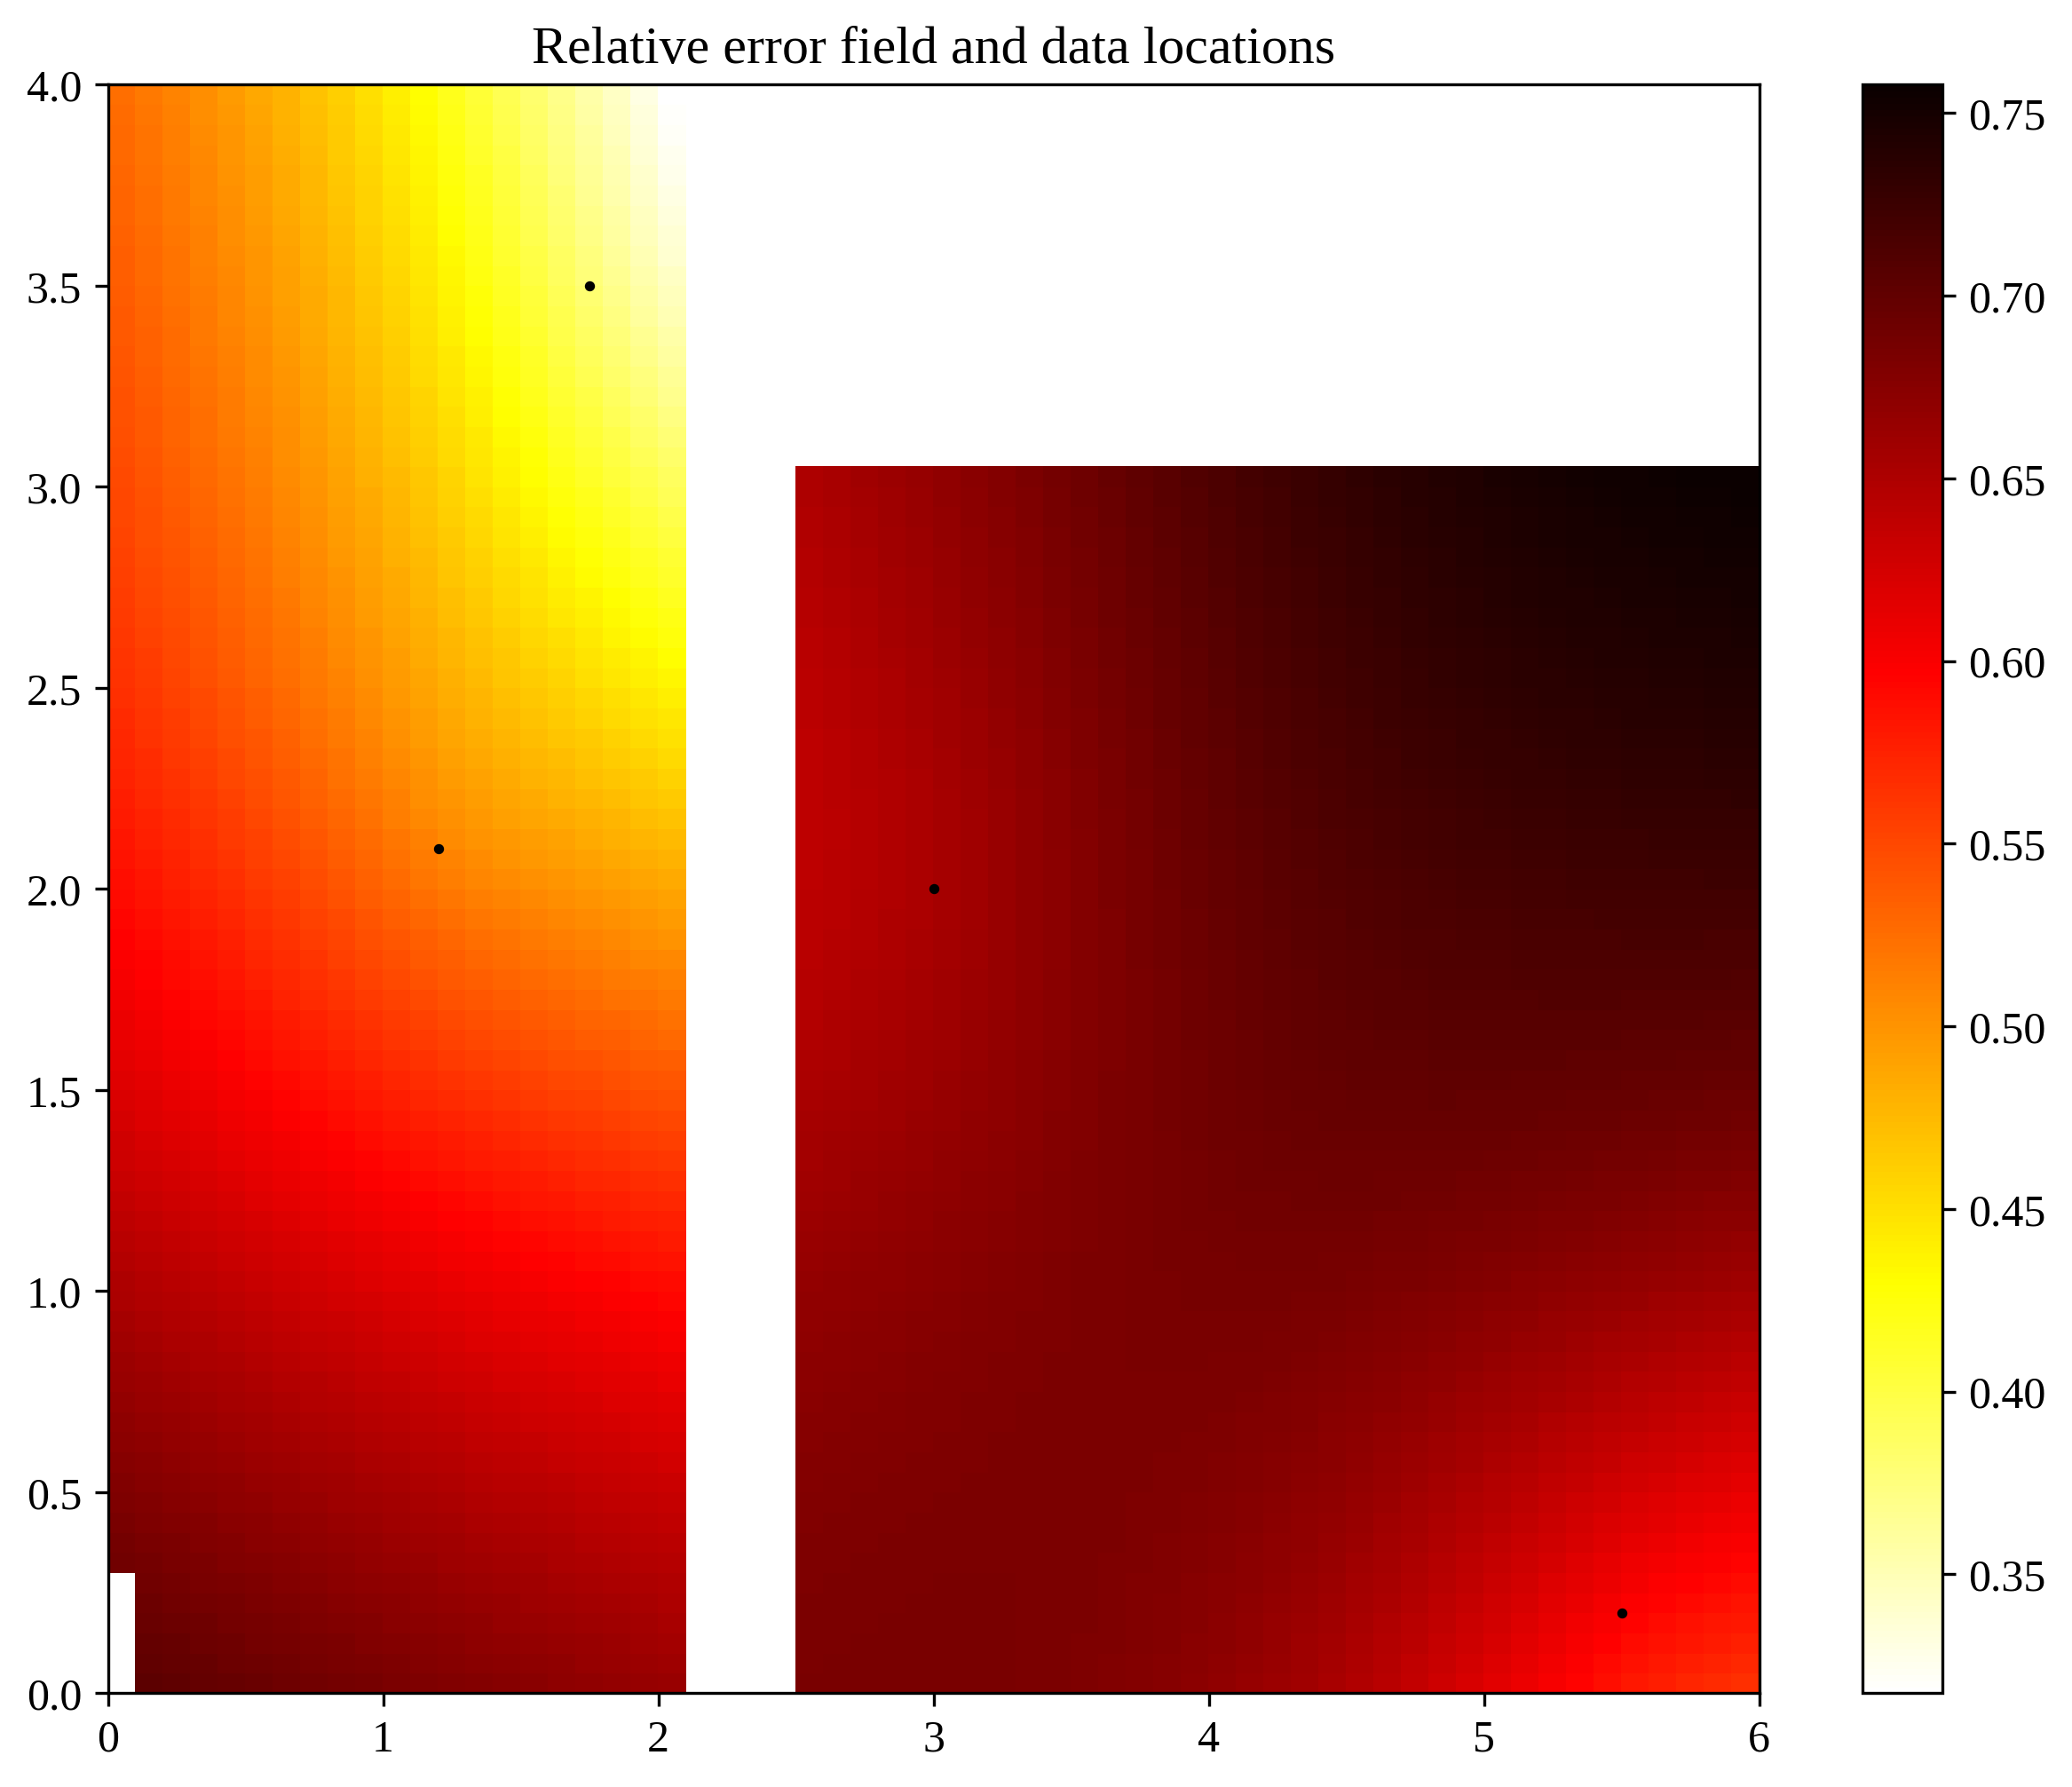

In [25]:
fig = plt.figure()
ax = plt.subplot(111)
errorfield = results2D.add_to_plot('error', cmap=plt.cm.hot_r)
data2D.add_positions_to_plot(s=3, color='k')
plt.colorbar(errorfield)
plt.title('Relative error field and data locations')
plt.show()
plt.close()

## Finite-element mesh

It is also interesting to display the finite-element mesh that covers our domain of interest.<br>
First we create a `Mesh` object, then we read the mesh from the 2 corresponding files.

In [26]:
mesh2D = pydiva2d.Diva2DMesh()
mesh2D.read_from(DivaFiles.mesh, DivaFiles.meshtopo)

2017-06-09 11:53:49,346 - pydiva2d - INFO - Creating Diva 2D mesh object


The plot is prepared with the add_to_plot method:

2017-06-09 11:53:50,796 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:53:50,799 - pydiva2d - DEBUG - Adding finite-element mesh to plot
2017-06-09 11:53:50,803 - pydiva2d - DEBUG - Setting limits to axes
2017-06-09 11:53:50,804 - pydiva2d - DEBUG - No projection defined
2017-06-09 11:53:50,805 - pydiva2d - DEBUG - Adding contours to plot


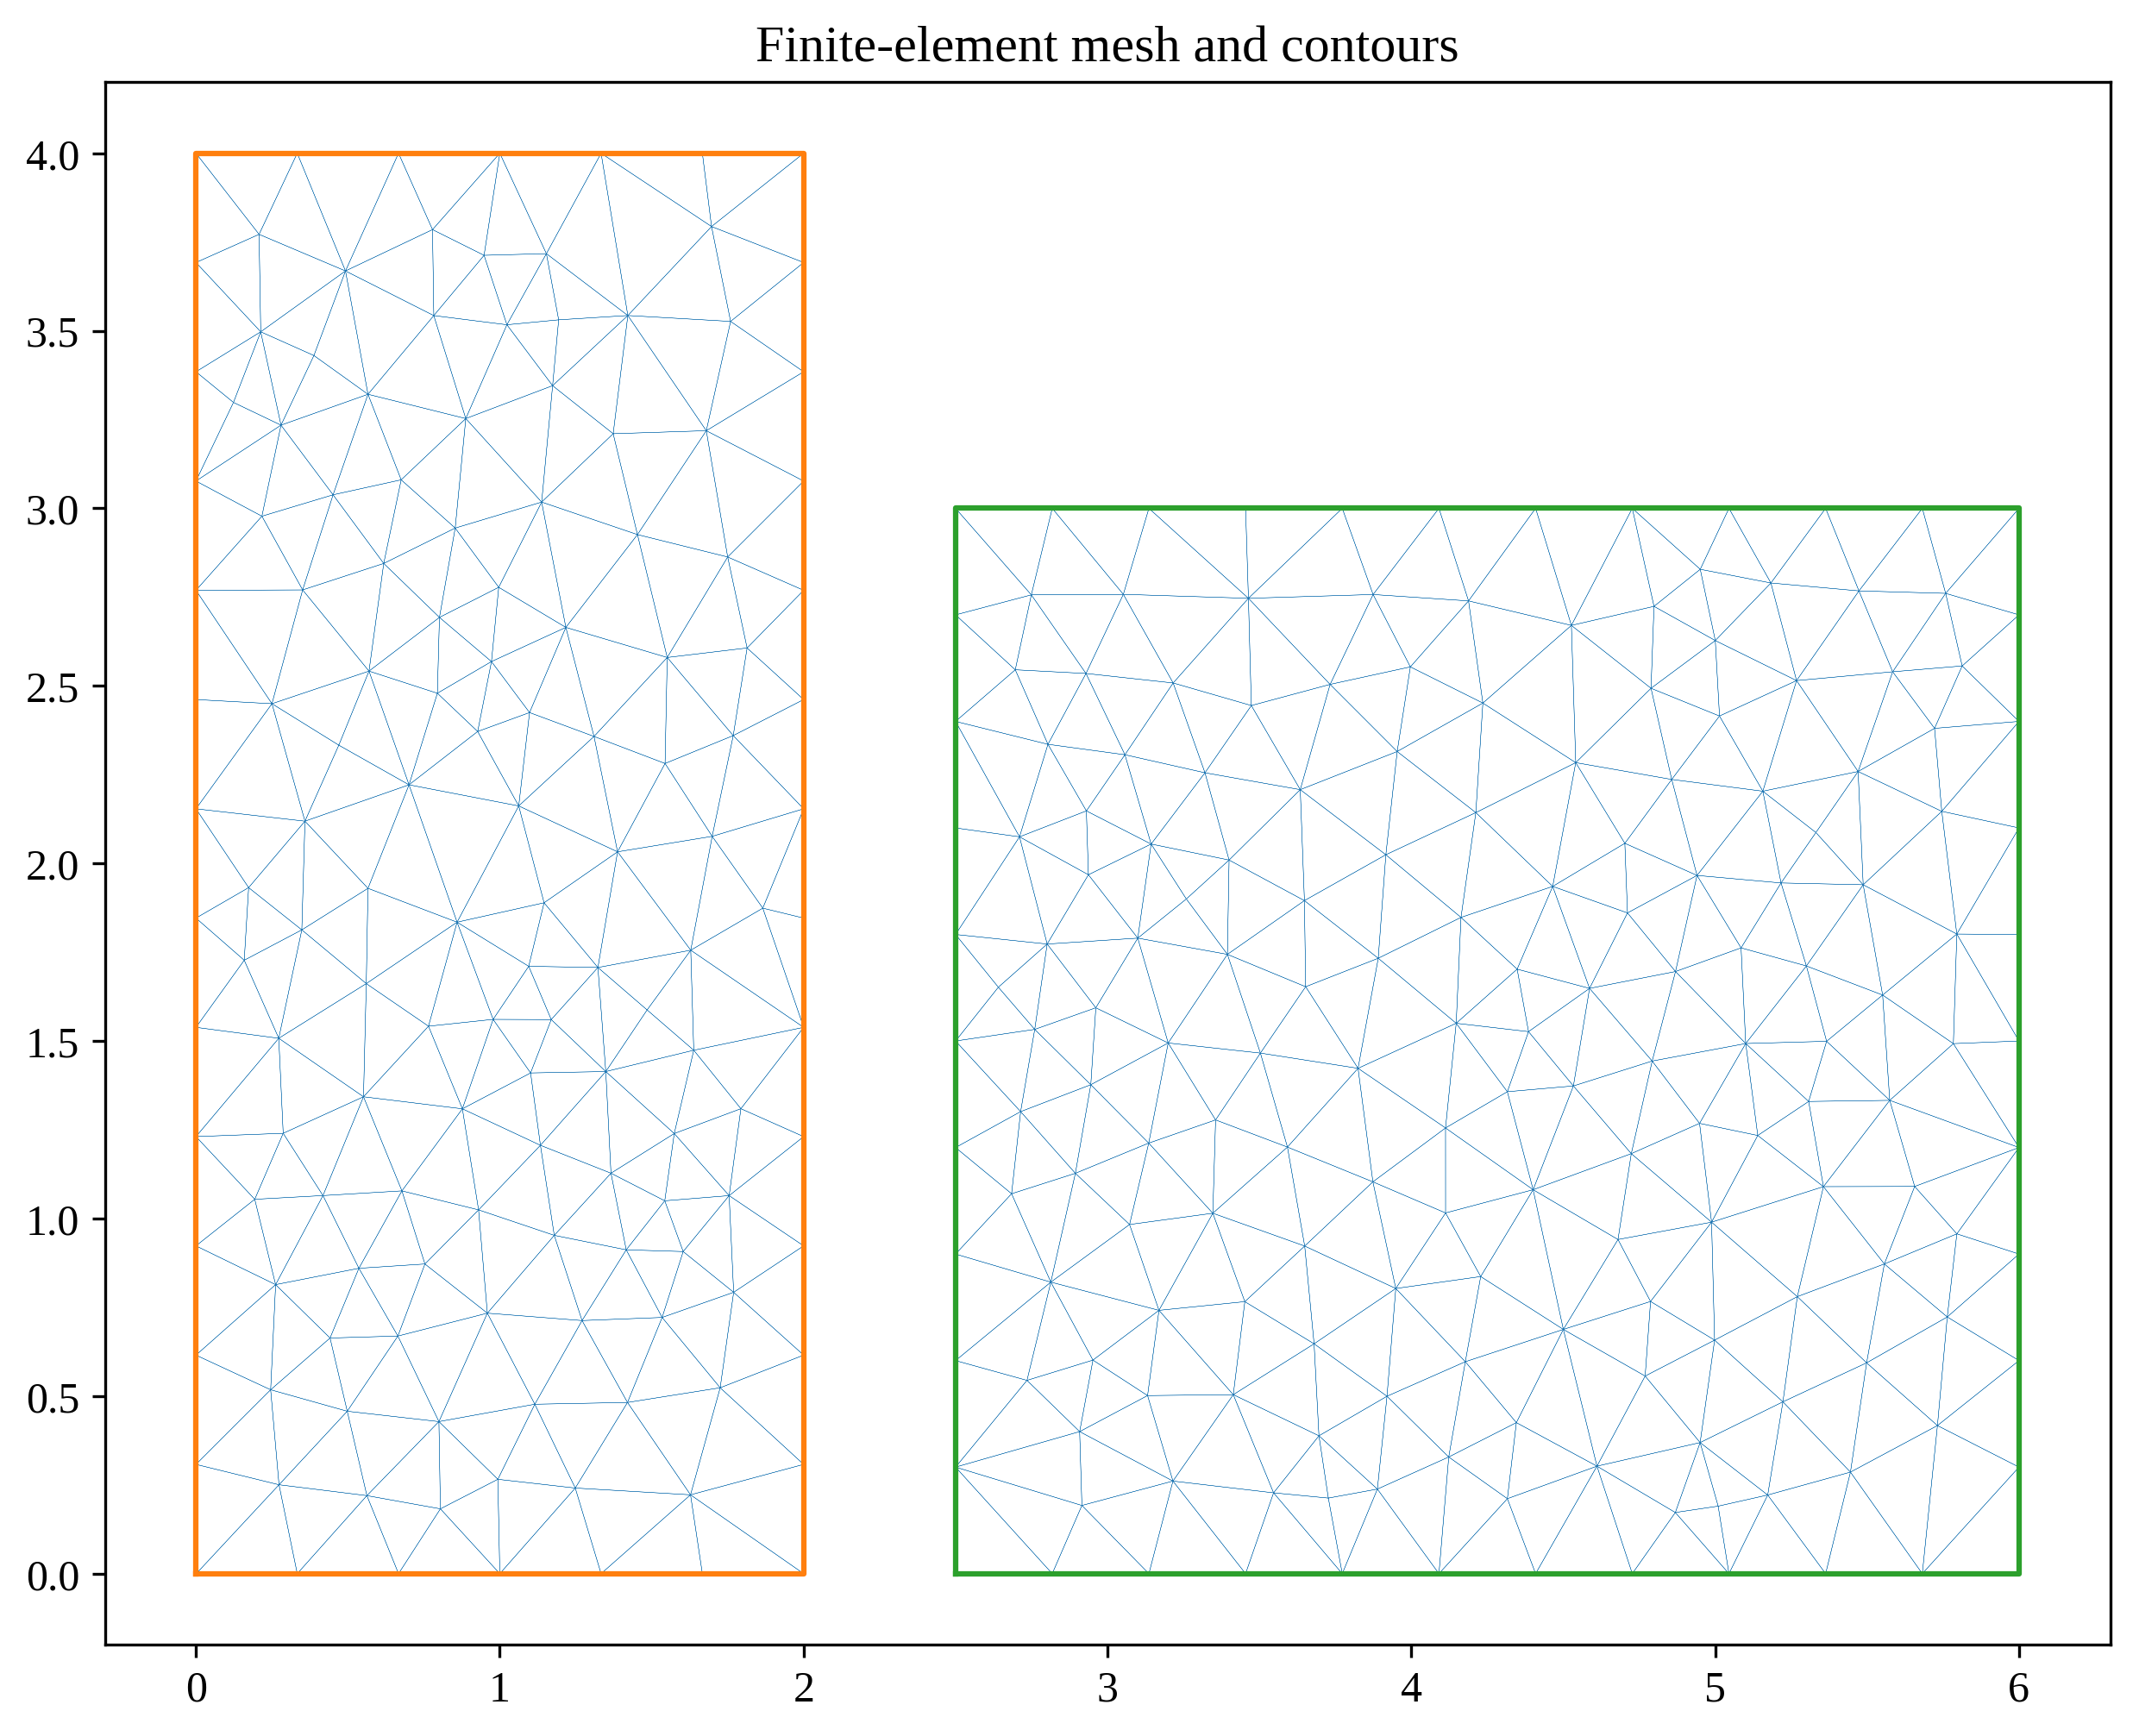

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
mesh2D.add_to_plot(lw=0.1)
contour2D.add_to_plot()
plt.title('Finite-element mesh and contours')
plt.show()
plt.close()